# Deepscent
Load the pre-trained Deepscent model and a set of data samples (dummy samples are provided). Use the model to predict their class.

In [84]:
#model_dir = '../data/model' 
#data_fname = '../data/test_data/thirty/events/events.txt' 
url_root = 'https://raw.githubusercontent.com/Withington/deepscent/master/data'
url_model_dir = url_root+'/model'
url_data_dir = url_root+'/test_data/thirty/events'

In [85]:
import sys
from pathlib import Path
import itertools
import csv
import requests
import json

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors
import seaborn as sns

np.random.seed(851)
sns.set(style="whitegrid")

load_local = True if not 'google.colab' in sys.modules else False

In [86]:
def load_data(filename):
    ''' Load a dataset from a file in UCR TSC Archive format
    i.e. space delimited, class labels in the first column.
    Returns
    X : input data, one sample per row
    Y : class labels corresponding to each row of X
    '''
    if 'google.colab' in sys.modules:
        return load_data_from_web(filename)
    else:
        return load_data_from_local(filename)


def load_data_from_local(filename):
    ''' Load the data from a local file
    File format - UCR TSC Archive
    i.e. space delimited, class labels in the first column.
    Returns
    X : input data, one sample per row
    Y : class labels corresponding to each row of X
    '''
    data = np.loadtxt(Path(filename))
    Y = data[:,0]
    X = data[:,1:]
    return X, Y


def load_data_from_web(url):
    ''' Load the data from a file in the deepscent GitHub repo.
    File format - UCR TSC Archive
    i.e. space delimited, class labels in the first column.
    Returns
    X : input data, one sample per row
    Y : class labels corresponding to each row of X
    '''
    df = pd.read_csv(url, sep=' ', header=None)
    print('Loaded data from', url)
    Y = df.values[:,0].astype(int)
    X = df.values[:,1:]
    return X, Y


def plot_confusion_matrix(cm):
    ''' Plot the normalised confusion matrix
    Parameters
    cm : array - normalised confusion matrix
    Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
    'Confusion Matrix' https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    '''
    classes = ['Positive', 'Negative']
    cmap=plt.cm.Blues
    sns.set_style('dark')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Normalised confusion matrix')
    plt.colorbar(format=FuncFormatter('{0:.0%}'.format))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.clim(0, 1)
    fmt = '.0%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    sns.set(style = 'whitegrid')

In [87]:
# Load the model structure
response = requests.get(url_model_dir+'/model.json')
model = model_from_json(json.dumps(response.json()))

# Load weights into new model
response = requests.get(url_model_dir+'/model.h5')
open('temp.h5', 'wb').write(response.content)
model.load_weights('temp.h5')
print('Model loaded from', url_model_dir)

# Load additional model parameters - used to normalise the input data and to set the classification threshold
model_params = pd.read_csv(url_model_dir+'/model_params.csv', header=None, index_col=0, squeeze=True).to_dict()

# Compile the model
optimizer = keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model loaded from https://raw.githubusercontent.com/Withington/deepscent/master/data/model


In [88]:
# Load data samples and normalise them
x_input, y_input = load_data_from_web(url_data_dir+'/events.txt') 
x_input_norm = (x_input - model_params['x_train_mean'])/(model_params['x_train_std'])

Loaded data from https://raw.githubusercontent.com/Withington/deepscent/master/data/test_data/thirty/events/events.txt


Class balance:	 0.6538461538461539 (class 0: 17 and class 1: 9 )
Accuracy:	 0.7307692307692307 



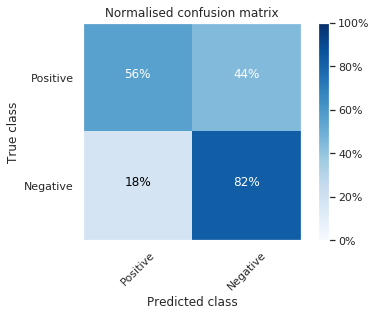

In [89]:
# Use the model to make predictions
y_probs = model.predict_on_batch(x_input_norm)
y_pred = y_probs.flatten()
y_pred[y_pred > model_params['threshold']] = 1
y_pred[y_pred <= model_params['threshold']] = 0

cm = confusion_matrix(y_input, y_pred, labels=[1,0])
acc_calc = (cm[0][0]+cm[1][1])/(cm.sum())
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
n0 = (y_input == 0).sum()
n1 = (y_input == 1).sum()

print('Class balance:\t', n0/(n0+n1), '(class 0:',n0, 'and class 1:', n1, ')')
print('Accuracy:\t',acc_calc, '\n')
plot_confusion_matrix(cm_norm)

Text(0.5, 1.0, 'Data sample 0\nTrue class 0: Model prediction 0')

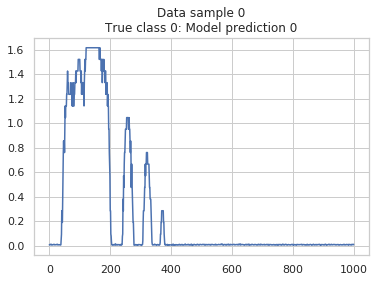

In [90]:
# Plot a data sample
fig, ax = plt.subplots(1, 1)
i = 0
ax.plot(x_input[i])
ax.set_title('Data sample '+str(i)+'\nTrue class '+str(int(y_input[i]))+': Model prediction '+str(int(y_pred[i])))

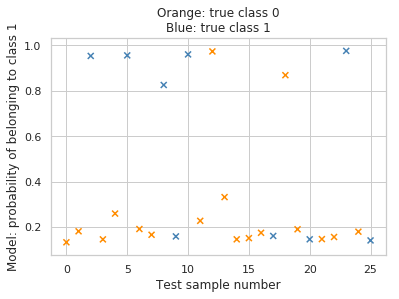

In [91]:
# Plot classification probabilities
class_colors = ['darkorange', 'steelblue']
x = np.arange(y_probs.shape[0])
class_cmap = matplotlib.colors.ListedColormap(class_colors)
fig, ax = plt.subplots()
plt.scatter(np.arange(y_probs.shape[0]), y_probs, linestyle='None', marker='x', 
            c=y_input, cmap=class_cmap)
plt.title('Orange: true class 0\nBlue: true class 1')
ax.set_xlabel('Test sample number')
ax.set_ylabel('Model: probability of belonging to class 1');